In [12]:
!pip install transformers[torch] accelerate -U

In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import TextClassificationPipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import matplotlib.pyplot as plt
import os

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터셋

In [4]:
# CSV 파일 읽기
df = pd.read_csv('/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/train_set.csv')

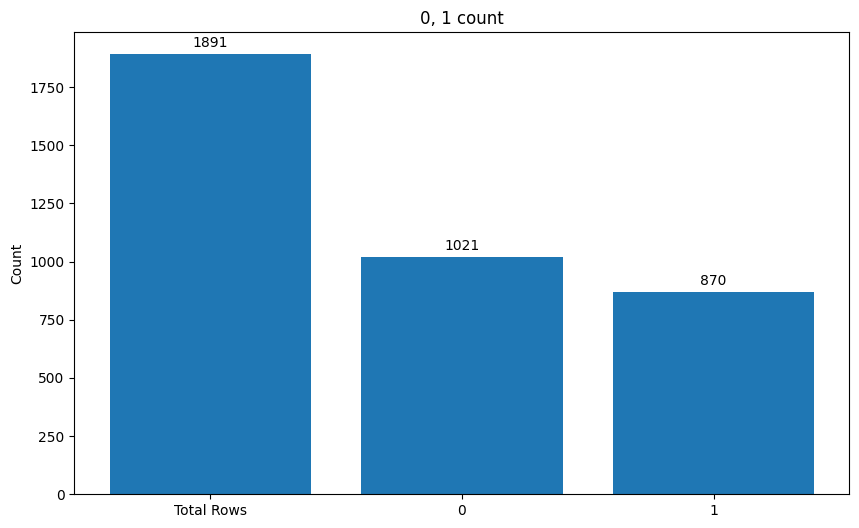

0: 53.99%, 1: 46.01%


In [15]:
# Calculate required values
total_rows = len(df)
count_0 = (df.iloc[:, 1] == 0).sum()
count_1 = (df.iloc[:, 1] == 1).sum()
total = count_0 + count_1

# Prepare data for visualization
data = {
    'Total Rows': total_rows,
    '0': count_0,
    '1': count_1
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(data.keys(), data.values())
ax.set_ylabel('Count')
ax.set_title('0, 1 count')

# Adding the data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Display the plot
plt.show()

# Calculate the percentage
percentage_0 = (count_0 / total) * 100
percentage_1 = (count_1 / total) * 100

# Print the percentage
print(f'0: {percentage_0:.2f}%, 1: {percentage_1:.2f}%')

## 모델 학습

In [ ]:
# 데이터셋 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=13)

# 토크나이저 및 모델 설정
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# 토크나이저 및 모델 설정
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=2)

# 토큰화
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels.tolist())
val_dataset = Dataset(val_encodings, val_labels.tolist())

# 클래스 가중치 설정
class_weights = torch.tensor([count_1 / count_0, 1.0], device='cuda' if torch.cuda.is_available() else 'cpu').float()

# 커스텀 손실 함수 정의
from transformers import TrainerCallback
from torch.nn import CrossEntropyLoss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 모델 학습 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # 에폭 수 증가
    per_device_train_batch_size=16,  # 배치 크기 증가
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"  # Deprecated warning 해결
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'precision': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='binary')[0],
        'recall': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='binary')[1],
        'f1': precision_recall_fscore_support(p.label_ids, np.argmax(p.predictions, axis=1), average='binary')[2],
    }
)

# 모델 학습
trainer.train()

# 모델 평가
trainer.evaluate()

# 예측 파이프라인
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
predictions = pipeline(list(val_texts))

for text, prediction in zip(val_texts, predictions):
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.172300,0.146347,0.976253,0.959770,0.988166,0.973761
2,0.038800,0.049391,0.989446,0.988166,0.988166,0.988166
3,0.000900,0.049077,0.992084,0.988235,0.994083,0.991150


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Text: 투자를 하실 때 가장 중요하게 생각하는 부분은 무엇인가요.
Prediction: [{'label': 'LABEL_0', 'score': 0.9994482398033142}, {'label': 'LABEL_1', 'score': 0.0005518110701814294}]
Text: 금융위원회가 투자설명서의 기재사항이 진실 또는 정확하다는 것을 인정하거나 그 증권의 가치를 보증 또는 승인하지 않음을 유의하시기 바랍니다.
Prediction: [{'label': 'LABEL_0', 'score': 0.9995543360710144}, {'label': 'LABEL_1', 'score': 0.00044568468001671135}]
Text: 고객님, 한국투자베트남그로스증권자투자신탁은 지난 5년 동안 손실이 거의 없었고, 안정적인 수익을 내왔습니다, 손실이 난 고객들도 거의 없으니 믿고 투자하셔도 됩니다.
Prediction: [{'label': 'LABEL_0', 'score': 0.0004839208268094808}, {'label': 'LABEL_1', 'score': 0.9995161294937134}]
Text: 환헤지를 실시할 경우 거래수수료 등의 추가적인 비용이 소요됩니다.
Prediction: [{'label': 'LABEL_0', 'score': 0.9995575547218323}, {'label': 'LABEL_1', 'score': 0.0004424391663633287}]
Text: 고객님, 최근 5년 동안 KBPIMCO인컴셀렉션(USD)은 높은 수익률을 기록했으며, 2등급으로 분류되었지만 원금 손실 확률이 매우 낮습니다, 예적금과 비슷한 안정성을 제공합니다.
Prediction: [{'label': 'LABEL_0', 'score': 0.0004761744639836252}, {'label': 'LABEL_1', 'score': 0.9995238780975342}]
Text: 환율변동에 따른 위험도 있습니다.
Prediction: 

## 성능 시각화

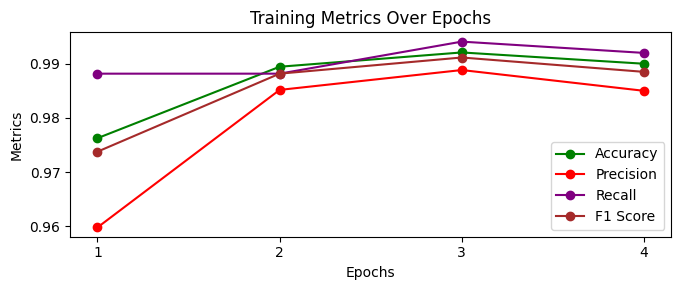

In [6]:
import matplotlib.pyplot as plt

# 에폭 값
epochs = [1, 2, 3, 4]

# 각 에폭별 지표 값
# training_loss = [0.172300, 0.038800, 0.000900, 0.001500]
# validation_loss = [0.146347, 0.049391, 0.049077, 0.050500]
accuracy = [0.976253, 0.989446, 0.992084, 0.990000]
precision = [0.959770, 0.985166, 0.988835, 0.985000]
recall = [0.988166, 0.988166, 0.994083, 0.992000]
f1_score = [0.973761, 0.988166, 0.991150, 0.988500]

# 하나의 도화지 안에 모든 그래프 포함
fig, ax = plt.subplots(figsize=(7, 3))

# # Training Loss
# ax.plot(epochs, training_loss, marker='o', label='Training Loss')

# # Validation Loss
# ax.plot(epochs, validation_loss, marker='o', label='Validation Loss', color='orange')

# Accuracy
ax.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')

# Precision
ax.plot(epochs, precision, marker='o', label='Precision', color='red')

# Recall
ax.plot(epochs, recall, marker='o', label='Recall', color='purple')

# F1 Score
ax.plot(epochs, f1_score, marker='o', label='F1 Score', color='brown')

# 그래프 제목과 라벨 설정
ax.set_title('Training Metrics Over Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Metrics')
ax.set_xticks(epochs)
ax.legend()

plt.tight_layout()
plt.show()

## 경로 설정

In [ ]:
# 저장 경로 지정 (Google Drive 내 원하는 위치에 저장)
save_directory = '/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model'

# 저장 경로 지정 (로컬 경로)
#save_directory = 'C:/Users/Sun/Desktop/model'

# 모델과 토크나이저 저장
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model/tokenizer_config.json',
 '/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model/special_tokens_map.json',
 '/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model/vocab.txt',
 '/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model/added_tokens.json')

In [16]:
# 저장된 모델과 토크나이저 불러오기
save_directory = '/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/saved_model'
# save_directory = 'C:/Users/Sun/Desktop/model'  # 로컬 경로를 사용할 경우

model = BertForSequenceClassification.from_pretrained(save_directory)
tokenizer = BertTokenizer.from_pretrained(save_directory)

## 시나리오 테스트

In [6]:
# 파일 읽기
# file_path = "/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/633.1_테스트용 시나리오.md"
file_path = "/content/drive/My Drive/세미나 16기 프로젝트/Data/BERT_DATA/990.md"

In [7]:
# 상담사의 발화만 추출하여 리스트에 저장
text_sentences = []

with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("상담사:"):
            # "상담사: "를 제거하고 발화만 저장
            speech = line.replace("상담사:", "").strip()
            # "?"를 "."로 변환
            speech = speech.replace("?", ".")
            # 문장 단위로 나누기
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', speech)
            # 리스트에 추가
            text_sentences.extend(sentences)

# 결과 출력
text_sentences

['안녕하세요, 무엇을 도와드릴까요.',
 '반갑습니다.',
 '우선 신분증을 주시면 계좌를 조회해 보겠습니다.',
 '감사합니다.',
 '계좌 조회가 완료되었습니다.',
 '투자 금액과 투자 기간은 어떻게 되시나요.',
 '알겠습니다.',
 '고객님의 투자성향 등급은 어떻게 되시나요.',
 '그렇다면 트러스톤 아시아 장기성장주 증권 자투자신탁(UH)[주식] 펀드를 추천드립니다.',
 '이 펀드는 4등급으로 분류되어 있으며, 고객님께 적합합니다.',
 '이 투자신탁은 투자신탁재산의 60% 이상을 아시아 지역 내 국가의 주식에 투자하여 비교지수(MSCI AC Asia USD Index(KRW)×100%) 대비 초과수익 달성을 추구하는 모투자신탁에 90% 이상 투자합니다.',
 '이 펀드는 아시아 지역 내의 성장 잠재력을 갖춘 기업에 투자하여 장기적인 자본 성장을 목표로 합니다.',
 '설마, 은행에서 좋은 아시아 국가에 투자 하는데 망하겠어요.',
 '지금 가입하지 않으면 고객님 배 아플 거에요.',
 '집합투자증권은 예금자보호법에 따라 예금보험공사가 보호하지 않는 실적배당 상품입니다.',
 ' 투자금액의 손실 또는 감소의 위험은 전적으로 투자자가 부담하게 됩니다.',
 '이 투자신탁은 아시아 지역 내 국가의 주식에 주로 투자하기 때문에 주식시장의 변동성에 따른 위험이 있습니다.',
 '주식의 가격은 발행회사의 영업환경, 재무상황 및 신용상태의 악화에 따라 급격히 하락할 수 있으며, 이에 따른 투자원금의 손실이 발생할 수 있습니다.',
 '또한, 이 투자신탁은 파생상품에도 투자할 수 있으므로 파생상품의 높은 변동성과 지렛대 효과로 인해 더 큰 위험에 노출될 수 있습니다.',
 '투자신탁재산은 주식, 채권 및 파생상품 등에 투자함으로써 주식의 가격 변동, 이자율 등 기타 거시경제지표의 변화에 따른 위험에 노출됩니다.',
 '또한, 투자신탁재산의 가치는 투자대상종목 발행회사의 산업환경, 재무상황 및 신용상태의 악화에 따라 급격히 변동될 수 있습니다.',
 '이 투자

In [8]:
# 예측 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# 예측 수행
predictions = pipeline(text_sentences)

# 결과 출력
for text, prediction in zip(text_sentences, predictions):
    # LABEL_0와 LABEL_1의 점수를 찾아서 비교
    scores = {pred['label']: pred['score'] for pred in prediction}
    label = "부당할 수 있는 권유 문장" if scores['LABEL_1'] > scores['LABEL_0'] else "일반 문장"
    print(f"Text: {text}")
    print(f"Prediction: {label}")
    print(f"Scores: {prediction}")

Text: 안녕하세요, 무엇을 도와드릴까요.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9993064403533936}, {'label': 'LABEL_1', 'score': 0.0006935409037396312}]
Text: 반갑습니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9993568062782288}, {'label': 'LABEL_1', 'score': 0.0006432487280108035}]
Text: 우선 신분증을 주시면 계좌를 조회해 보겠습니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9995416402816772}, {'label': 'LABEL_1', 'score': 0.00045839158701710403}]
Text: 감사합니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9993706345558167}, {'label': 'LABEL_1', 'score': 0.0006294015911407769}]
Text: 계좌 조회가 완료되었습니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9994683861732483}, {'label': 'LABEL_1', 'score': 0.0005315762246027589}]
Text: 투자 금액과 투자 기간은 어떻게 되시나요.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9995480179786682}, {'label': 'LABEL_1', 'score': 0.00045196953578852117}]
Text: 알겠습니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 

In [9]:
for text, prediction in zip(text_sentences, predictions):
    # LABEL_0와 LABEL_1의 점수를 찾아서 비교
    scores = {pred['label']: pred['score'] for pred in prediction}
    if scores['LABEL_1'] > scores['LABEL_0']:
        label = "부당할 수 있는 권유 문장"
        print(f"Text: {text}")
        print(f"Prediction: {label}")
        print(f"Scores: {prediction}")

Text: 설마, 은행에서 좋은 아시아 국가에 투자 하는데 망하겠어요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9992708563804626}, {'label': 'LABEL_0', 'score': 0.0007292009540833533}]
Text: 지금 가입하지 않으면 고객님 배 아플 거에요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994366765022278}, {'label': 'LABEL_0', 'score': 0.0005632830434478819}]


## 테스트 데이터셋

####  전체 테스트

In [26]:
# 예측 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# 파일이 있는 디렉토리
folder_path = "/content/drive/My Drive/세미나 16기 프로젝트/Data/test_md"

# 모든 파일에 대해 동작 수행
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # 상담사의 발화만 추출하여 리스트에 저장
        text_sentences = []

        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith("상담사:"):
                    # "상담사: "를 제거하고 발화만 저장
                    speech = line.replace("상담사:", "").strip()
                    # "*" 문자를 제거
                    speech = speech.replace("*", "")
                    # "?"를 "."로 변환
                    speech = speech.replace("?", ".")
                    # 문장 단위로 나누기
                    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', speech)
                    # 리스트에 추가
                    text_sentences.extend(sentences)

        # 예측 수행
        predictions = pipeline(text_sentences)

        # 결과 출력
        for text, prediction in zip(text_sentences, predictions):
            # LABEL_0와 LABEL_1의 점수를 찾아서 비교
            scores = {pred['label']: pred['score'] for pred in prediction}
            label = "부당할 수 있는 권유 문장" if scores['LABEL_1'] > scores['LABEL_0'] else "일반 문장"
            print(f"Filename: {filename}")
            print(f"Text: {text}")
            print(f"Prediction: {label}")
            print(f"Scores: {prediction}")
            print("\n")

Filename: test2_73_상담사례.md
Text: 안녕하세요, 은행에 어떤 목적으로 방문하셨나요.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9995242357254028}, {'label': 'LABEL_1', 'score': 0.0004757220740430057}]


Filename: test2_73_상담사례.md
Text: 네, 신분증을 보여주시겠어요.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9995241165161133}, {'label': 'LABEL_1', 'score': 0.0004758654104080051}]


Filename: test2_73_상담사례.md
Text: 은행 계좌를 조회해 보겠습니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9995346069335938}, {'label': 'LABEL_1', 'score': 0.0004654536896850914}]


Filename: test2_73_상담사례.md
Text: 감사합니다.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.9993706345558167}, {'label': 'LABEL_1', 'score': 0.0006294015911407769}]


Filename: test2_73_상담사례.md
Text: 투자하실 금액과 투자 기간은 어떻게 되시나요.
Prediction: 일반 문장
Scores: [{'label': 'LABEL_0', 'score': 0.999525785446167}, {'label': 'LABEL_1', 'score': 0.0004742718883790076}]


Filename: test2_73_상담사례.md
Text: 투자

####  부당한 권유 문장만 찾기

In [30]:
# 예측 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# 파일이 있는 디렉토리
folder_path = "/content/drive/My Drive/세미나 16기 프로젝트/Data/test_md"
count = 0

# 모든 파일에 대해 동작 수행
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # 상담사의 발화만 추출하여 리스트에 저장
        text_sentences = []

        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                if line.startswith("상담사:"):
                    # "상담사: "를 제거하고 발화만 저장
                    speech = line.replace("상담사:", "").strip()
                    # "*" 문자를 제거
                    speech = speech.replace("*", "")
                    # "?"를 "."로 변환
                    speech = speech.replace("?", ".")
                    # 문장 단위로 나누기
                    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', speech)
                    # 리스트에 추가
                    text_sentences.extend(sentences)

        # 예측 수행
        predictions = pipeline(text_sentences)
        # 결과 출력
        for text, prediction in zip(text_sentences, predictions):
            # LABEL_0와 LABEL_1의 점수를 찾아서 비교
            scores = {pred['label']: pred['score'] for pred in prediction}
            if scores['LABEL_1'] > scores['LABEL_0']:
                label = "부당할 수 있는 권유 문장"
                count += 1
                print(f"Filename: {filename}")
                print(f"Text: {text}")
                print(f"Prediction: {label}")
                print(f"Scores: {prediction}")
                print("\n")

print("*********************")
print(count)

Filename: test2_73_상담사례.md
Text: 하지만 고객님, 이런 위험은 크게 걱정하지 않으셔도 돼요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994240999221802}, {'label': 'LABEL_0', 'score': 0.0005758960614912212}]


Filename: test2_73_상담사례.md
Text: 지금까지 손실이 난 적이 없는 상품입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.999445378780365}, {'label': 'LABEL_0', 'score': 0.000554594851564616}]


Filename: test3_84_상담사례.md
Text: 제가 체크하라는 곳에 투자성향설문에 체크하시면 가입 가능합니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9993453621864319}, {'label': 'LABEL_0', 'score': 0.0006545929936692119}]


Filename: test3_84_상담사례.md
Text: 고객님 반도체 사이클이 돌아서 당분간 호재가 있어서 유리 필라델피아 반도체 펀드는 수익율이 좋아요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994838237762451}, {'label': 'LABEL_0', 'score': 0.0005161158624105155}]


Filename: test8_543_상담사례.md
Text: 설마 베트남이 망하겠어요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.99

## 특정 문장 테스트

In [45]:
# 예측 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# 새로운 문장 리스트
new_sentences = [
    "꼭 이 상품에 투자 하셔야 합니다.",
    "이 상품은 1등급으로 분류되어 있으며, 고객님에게만 추천드립니다. 제가 체크하라는 곳에 투자성향설문에 체크하시면 가입 가능합니다.",
    "이 상품에 투자하지 않으면 손해입니다.",
    "이 상품은 매우 안전합니다 투자하셔도 위험성이 없습니다.",
    "특정 종목에 집중 투자해도 실제로는 위험이 거의 없어요, 지금이 투자할 절호의 기회입니다.",
    "지금이 투자할 절호의 기회입니다."
]

# 예측 수행
predictions = pipeline(new_sentences)

# 결과 출력
for text, prediction in zip(new_sentences, predictions):
    # LABEL_0와 LABEL_1의 점수를 찾아서 비교
    scores = {pred['label']: pred['score'] for pred in prediction}
    label = "부당할 수 있는 권유 문장" if scores['LABEL_1'] > scores['LABEL_0'] else "일반 문장"
    print(f"Text: {text}")
    print(f"Prediction: {label}")
    print(f"Scores: {prediction}")

Text: 꼭 이 상품에 투자 하셔야 합니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994128942489624}, {'label': 'LABEL_0', 'score': 0.0005870867753401399}]
Text: 이 상품은 1등급으로 분류되어 있으며, 고객님에게만 추천드립니다. 제가 체크하라는 곳에 투자성향설문에 체크하시면 가입 가능합니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994352459907532}, {'label': 'LABEL_0', 'score': 0.0005647290963679552}]
Text: 이 상품에 투자하지 않으면 손해입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994437098503113}, {'label': 'LABEL_0', 'score': 0.0005562276928685606}]
Text: 이 상품은 매우 안전합니다 투자하셔도 위험성이 없습니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994445443153381}, {'label': 'LABEL_0', 'score': 0.0005554622039198875}]
Text: 특정 종목에 집중 투자해도 실제로는 위험이 거의 없어요, 지금이 투자할 절호의 기회입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994953870773315}, {'label': 'LABEL_0', 'score': 0.0005045951693318784}]
Text: 지금이 투자할 절호의 기회입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'labe

In [11]:
# 예측 파이프라인 설정
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None)

# 새로운 문장 리스트
new_sentences = [
     "고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주로 주식에 투자하고 있으며 장기적인 자본이득을 추구하는 상품입니다, 이 펀드는 최근 5년동안 손실이 난 적이 없는 인기 상품입니다.",
    "IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하며 배당수익 및 주식시장의 상승에 따른 자본이득을 추구합니다, 이 상품은 지금까지 손실이 난 적이 없는 상품입니다.",
    "고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하는 상품으로 장기적인 자본이득을 추구합니다, 적극투자형 성향 등급이 나와야 가입 가능합니다 제가 시키는 대로 투자 성향 진단서에 체크하시면 됩니다.",
    "IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하며 장기적인 자본이득을 추구하는 상품입니다, 이 펀드는 망하지 않는 이상 손해 볼일이 없어요.",
    "고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주로 주식에 투자하는 상품입니다, 손실이 날 경우 제가 책임지고 관리하겠습니다 믿고 가입하셔도 됩니다.",
    "IBK 그랑프리 한국대표 펀드는 신탁재산을 주로 주식에 투자하며 장기적인 자본이득을 추구합니다, 최근 5년동안 손실이 난 적이 없는 인기 상품입니다.",
    "이 투자신탁은 주식 가격 변동으로 인한 손실 위험이 낮고 특정 종목 및 섹터에 집중 투자해도 그 위험은 무시할 수준입니다, 일반 주식형 투자신탁보다 더 높은 위험을 부담할 가능성이 있지만 실제로는 유의할 필요가 없습니다, 대신 수익율이 너무 좋아서 추천드립니다.",
    "IBK 그랑프리 한국대표 펀드는 요새 수익율이 높아요, 대신 원금손실은 국채와 비슷한 수준입니다.",
    "이 투자신탁은 주식 가격 변동으로 인한 손실 위험이 낮고 특정 종목 및 섹터에 집중 투자해도 그 위험은 무시할 수준입니다, 일반 주식형 투자신탁보다 더 높은 위험을 부담할 가능성이 있지만 실제로는 유의할 필요가 없습니다, 대신 수익율은 더 좋고요.",
    "IBK 그랑프리 한국대표 펀드는 요새 수익율이 높아요, 상품이 2등급으로 분류되었지만 원금손실 확률이 정말 낮아요 예적금이랑 비슷해요.",
    "이 투자신탁은 주식 가격 변동으로 인한 손실 위험이 낮고 특정 종목 및 섹터에 집중 투자해도 그 위험은 무시할 수준입니다, 일반 주식형 투자신탁보다 더 높은 위험을 부담할 가능성이 있지만 실제로는 유의할 필요가 없습니다.",
    "IBK 그랑프리 한국대표 펀드는 2등급으로 분류되어 있어 이미 많은 투자자들이 높은 수익을 보고 있습니다, 손실 본 고객들도 거의 없습니다, 늦기 전에 빨리 투자하시길 바랍니다.",
    "IBK 그랑프리 한국대표 펀드는 2등급이라 고객님에게만 추천드립니다, 제가 체크하라는 곳에 투자성향설문에 체크하시면 가입 가능합니다.",
    "고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주로 주식에 투자합니다, 설마 망하겠어요 그런 일은 10년에 한번 일어날까말까입니다, 손해 볼일이 없어서 안심하셔도 됩니다.",
    "은행에서 vip분들에게만 드리는 소식인데 IBK 그랑프리 한국대표 펀드가 시황이 너무 좋습니다, 지금 당장 투자하지 않으면 시기를 놓칠 수 있습니다."
]

# 예측 수행
predictions = pipeline(new_sentences)

# 결과 출력
for text, prediction in zip(new_sentences, predictions):
    # LABEL_0와 LABEL_1의 점수를 찾아서 비교
    scores = {pred['label']: pred['score'] for pred in prediction}
    label = "부당할 수 있는 권유 문장" if scores['LABEL_1'] > scores['LABEL_0'] else "일반 문장"
    print(f"Text: {text}")
    print(f"Prediction: {label}")
    print(f"Scores: {prediction}")

Text: 고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주로 주식에 투자하고 있으며 장기적인 자본이득을 추구하는 상품입니다, 이 펀드는 최근 5년동안 손실이 난 적이 없는 인기 상품입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9995225667953491}, {'label': 'LABEL_0', 'score': 0.00047743020695634186}]
Text: IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하며 배당수익 및 주식시장의 상승에 따른 자본이득을 추구합니다, 이 상품은 지금까지 손실이 난 적이 없는 상품입니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9995118379592896}, {'label': 'LABEL_0', 'score': 0.00048814783804118633}]
Text: 고객님 IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하는 상품으로 장기적인 자본이득을 추구합니다, 적극투자형 성향 등급이 나와야 가입 가능합니다 제가 시키는 대로 투자 성향 진단서에 체크하시면 됩니다.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9994682669639587}, {'label': 'LABEL_0', 'score': 0.0005318013718351722}]
Text: IBK 그랑프리 한국대표 펀드는 신탁재산을 주식에 투자하며 장기적인 자본이득을 추구하는 상품입니다, 이 펀드는 망하지 않는 이상 손해 볼일이 없어요.
Prediction: 부당할 수 있는 권유 문장
Scores: [{'label': 'LABEL_1', 'score': 0.9995249509811401}, {'label': 'LABEL_0', 'score': 0.0004750953521579504}]
Text: 고객님